In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import numpy as np
import cv2                 
from random import shuffle
from tqdm import tqdm  
import tensorflow as tf 
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from collections import Counter

In [ ]:
tf.test.is_gpu_available()

True

## Explor data folders

In [ ]:
TrianImage="/kaggle/input/chest-xray-covid19-pneumonia/Data/train/"
TestImage="/kaggle/input/chest-xray-covid19-pneumonia/Data/test/"
Normalimages = os.listdir(TrianImage + "/NORMAL")
Pneumonaimages = os.listdir(TrianImage + "/PNEUMONIA")
COVID19images = os.listdir(TrianImage + "/COVID19")

In [ ]:
print(len(Normalimages), len(Pneumonaimages), len(COVID19images))
NUM_TRAINING_IMAGES = len(Normalimages) + len(Pneumonaimages) + len(COVID19images)
print(NUM_TRAINING_IMAGES)

1266 3418 460
5144


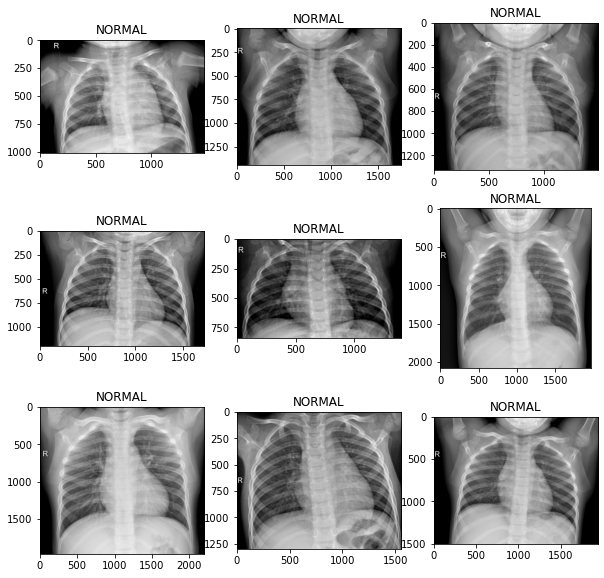

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/NORMAL",Normalimages[i])),cmap='gray')
    plt.title("NORMAL")
plt.show()

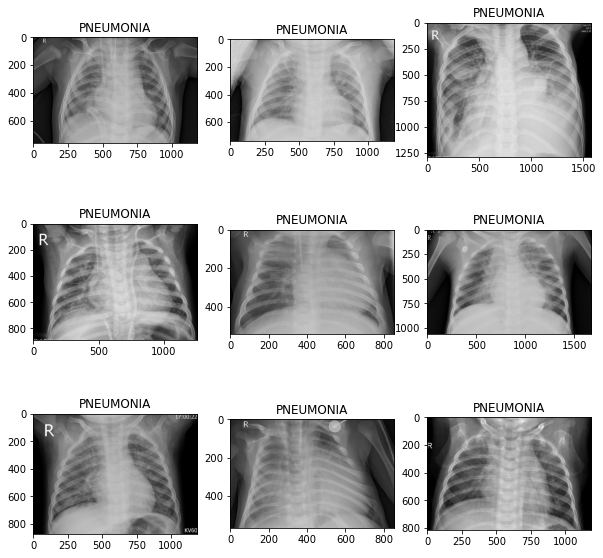

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/PNEUMONIA",Pneumonaimages[i])),cmap='gray')
    plt.title("PNEUMONIA")
plt.show()

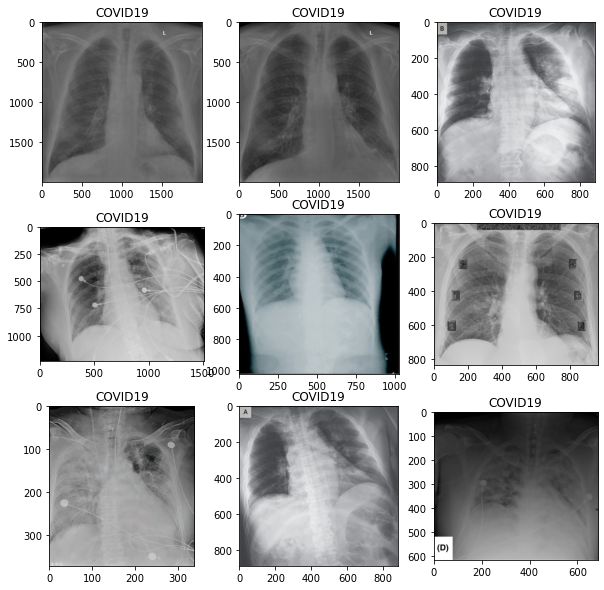

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/COVID19",COVID19images[i])),cmap='gray')
    plt.title("COVID19")
plt.show()

## Data sets 

In [ ]:
# https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

image_size = 224 
BATCH_SIZE = 16 
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

data_path = '/kaggle/input/chest-xray-covid19-pneumonia/Data'

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   rotation_range=15,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(data_path + '/train',
                                                 target_size = (image_size, image_size),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

testing_set = test_datagen.flow_from_directory(data_path + '/test',
                                            target_size = (image_size, image_size),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical',
                                            shuffle = True)

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
print("train batch ", training_set.__getitem__(0)[0].shape)
print("test batch ", testing_set.__getitem__(0)[0].shape)
print("sample train label \n", training_set.__getitem__(0)[1][:5])

train batch  (16, 224, 224, 3)
test batch  (16, 224, 224, 3)
sample train label 
 [[1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [ ]:
training_set.class_indices

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}

In [ ]:
testing_set.class_indices

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}

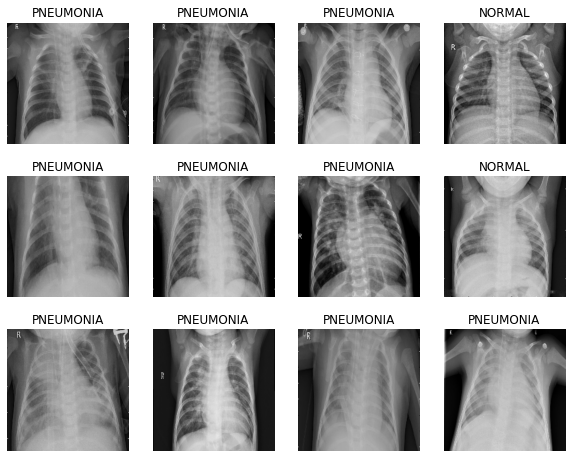

In [ ]:
labels = ['COVID19', 'NORMAL', 'PNEUMONIA']

sample_data = testing_set.__getitem__(1)[0] 
sample_label = testing_set.__getitem__(1)[1] 

plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.imshow(sample_data[i])
    plt.title(labels[np.argmax(sample_label[i])])

## Models

### Helpers

In [ ]:
!pip install efficientnet
import efficientnet.tfkeras as efn

     |████████████████████████████████| 50 kB 1.4 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [ ]:
# label smoothing https://www.linkedin.com/pulse/label-smoothing-solving-overfitting-overconfidence-code-sobh-phd/
def categorical_smooth_loss(y_true, y_pred, label_smoothing=0.1):
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)
    return loss

In [ ]:
# training call backs 
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, epsilon=0.0001, patience=3, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [ ]:
# https://stackoverflow.com/questions/42586475/is-it-possible-to-automatically-infer-the-class-weight-from-flow-from-directory
counter = Counter(training_set.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{0: 7.430434782608696, 1: 2.6998420221169037, 2: 1.0}

In [ ]:
# dfault input shapes 

print(tf.keras.applications.DenseNet201(weights='imagenet').input_shape)
print(efn.EfficientNetB7(weights='imagenet').input_shape) 
print(tf.keras.applications.VGG16(weights='imagenet').input_shape) 

82526208/82524592 [==============================] - 0s 0us/step
(None, 224, 224, 3)
268320768/268317848 [==============================] - 4s 0us/step
(None, 600, 600, 3)
553467904/553467096 [==============================] - 3s 0us/step
(None, 224, 224, 3)


### Pretrained densenet

In [ ]:
pretrained_densenet = tf.keras.applications.DenseNet201(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

for layer in pretrained_densenet.layers:
  layer.trainable = False

x1 = pretrained_densenet.output
x1 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x1)
x1 = tf.keras.layers.Flatten(name="flatten_head")(x1)
x1 = tf.keras.layers.Dense(64, activation="relu", name="dense_head")(x1)
x1 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x1)
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions_head")(x1)

model_densenet = Model(inputs=pretrained_densenet.input, outputs=model_out)
model_densenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=categorical_smooth_loss,metrics=['accuracy'])

model_densenet.summary()

74842112/74836368 [==============================] - 1s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________

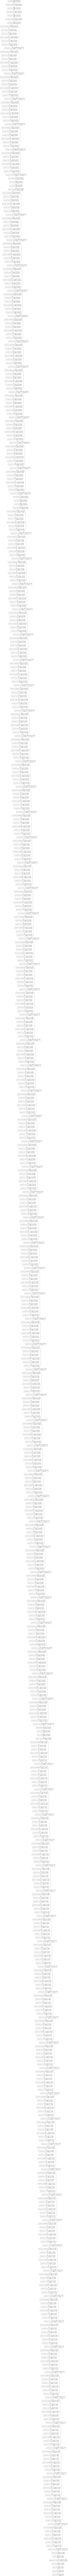

In [ ]:
plot_model(model_densenet, show_shapes=True, to_file='model_densenet.png')

In [ ]:
history_densenet = model_densenet.fit_generator(training_set, validation_data=testing_set, callbacks=[lr_reduce, es_callback], epochs=15)   

Epoch 1/15
322/322 [==============================] - 191s 592ms/step - loss: 0.4557 - accuracy: 0.9372 - val_loss: 0.4261 - val_accuracy: 0.9363
Epoch 2/15
322/322 [==============================] - 190s 589ms/step - loss: 0.4530 - accuracy: 0.9376 - val_loss: 0.4232 - val_accuracy: 0.9340
Epoch 3/15
322/322 [==============================] - 191s 593ms/step - loss: 0.4451 - accuracy: 0.9448 - val_loss: 0.4374 - val_accuracy: 0.9293
Epoch 4/15
322/322 [==============================] - 188s 585ms/step - loss: 0.4411 - accuracy: 0.9475 - val_loss: 0.4356 - val_accuracy: 0.9332
Epoch 5/15
322/322 [==============================] - ETA: 0s - loss: 0.4353 - accuracy: 0.9493
Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
322/322 [==============================] - 189s 586ms/step - loss: 0.4353 - accuracy: 0.9493 - val_loss: 0.4273 - val_accuracy: 0.9379
Epoch 6/15
322/322 [==============================] - 188s 584ms/step - loss: 0.4195 - accuracy: 0.9555 -

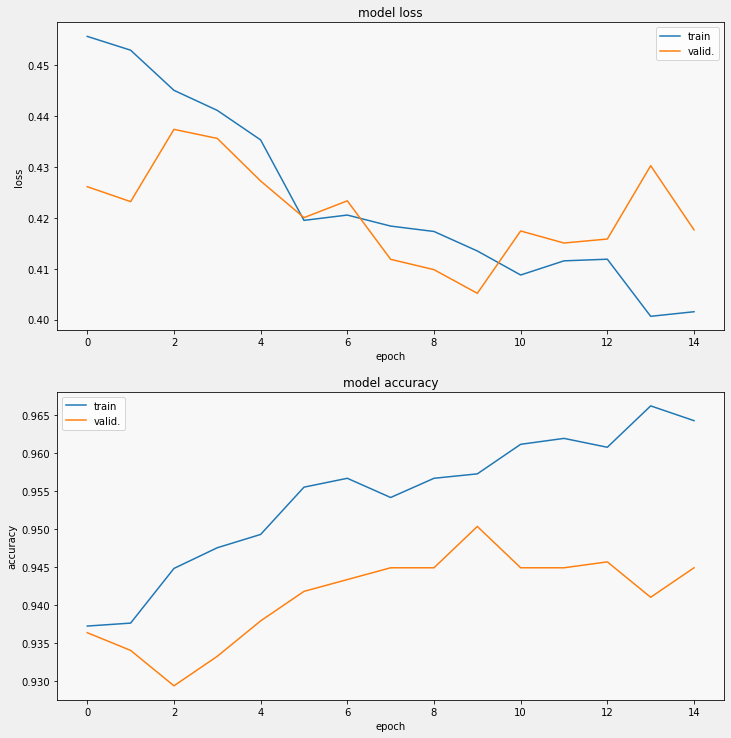

In [ ]:
display_training_curves(history_densenet.history['loss'], history_densenet.history['val_loss'], 'loss', 211)
display_training_curves(history_densenet.history['accuracy'], history_densenet.history['val_accuracy'], 'accuracy', 212)

## Prediction Sample

In [ ]:
last_conv_layer_name = "conv5_block32_concat"
classifier_layer_names = [
    "bn",
    "relu",
    "averagepooling2d_head",
    "flatten_head",
    "dense_head",
    "dropout_head",
    "predictions_head"
]

In [ ]:
# test image
file_path =  '/test/COVID19/COVID19(164).jpg'
test_image = cv2.imread(data_path + file_path)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)

error: OpenCV(4.4.0) /tmp/pip-req-build-njn2fp78/opencv/modules/imgproc/src/resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [ ]:
heatmap, top_index = make_gradcam_heatmap(test_image, model_densenet, last_conv_layer_name, classifier_layer_names)
print("predicted as", labels[top_index])

AttributeError: 'NoneType' object has no attribute '_keras_mask'

In [ ]:
plt.matshow(heatmap)
plt.show()

NameError: name 'heatmap' is not defined

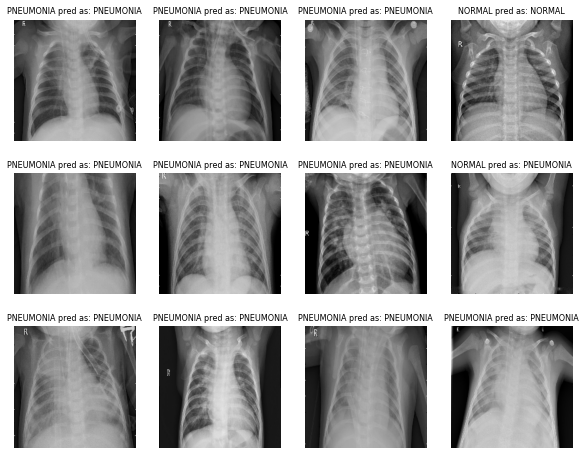

In [ ]:
# sample_data = testing_set.__getitem__(0)[0] 
# sample_label = testing_set.__getitem__(0)[1] 

plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')

    img = np.uint8(255 * sample_data[i])

    plt.imshow(img)
    plt.title(labels[np.argmax(sample_label[i])] + " pred as: " + labels[top_index], fontsize=8)
    

In [ ]:
model_densenet.save("model_densenet_30_09596.h5")

## Pretrained efnet

In [ ]:
# https://github.com/keras-team/keras/issues/9064
pretrained_efnet = efn.EfficientNetB7(input_shape=(image_size, image_size, 3), weights='noisy-student', include_top=False)

for layer in pretrained_efnet.layers:
  layer.trainable = False

x2 = pretrained_efnet.output
x2 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x2)
x2 = tf.keras.layers.Flatten(name="flatten_head")(x2)
x2 = tf.keras.layers.Dense(64, activation="relu", name="dense_head")(x2)
x2 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x2)
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions_head")(x2)

model_efnet = Model(inputs=pretrained_efnet.input, outputs=model_out)
model_efnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=categorical_smooth_loss,metrics=['accuracy'])
model_efnet.summary()

258072576/258068648 [==============================] - 3s 0us/step
Model: "functional_55"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 64) 1728        input_18[0][0]                   
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 64) 0           stem_bn[0][0]                    
___________________

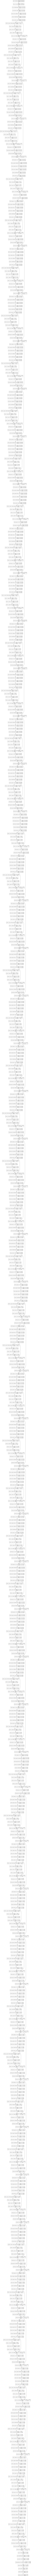

In [ ]:
plot_model(model_efnet, show_shapes=True, to_file='model_efnet.png')

In [ ]:
history_efnet = model_efnet.fit_generator(training_set, validation_data=testing_set, callbacks=[lr_reduce, es_callback], epochs=15)  

Epoch 1/15
322/322 [==============================] - 205s 636ms/step - loss: 0.7688 - accuracy: 0.7170 - val_loss: 0.6771 - val_accuracy: 0.7632
Epoch 2/15
322/322 [==============================] - 200s 621ms/step - loss: 0.6787 - accuracy: 0.7770 - val_loss: 0.5750 - val_accuracy: 0.8680
Epoch 3/15
322/322 [==============================] - 204s 633ms/step - loss: 0.6419 - accuracy: 0.8138 - val_loss: 0.6280 - val_accuracy: 0.7904
Epoch 4/15
322/322 [==============================] - 201s 623ms/step - loss: 0.6262 - accuracy: 0.8219 - val_loss: 0.5552 - val_accuracy: 0.8540
Epoch 5/15
322/322 [==============================] - 198s 616ms/step - loss: 0.6166 - accuracy: 0.8274 - val_loss: 0.6658 - val_accuracy: 0.7430
Epoch 6/15
322/322 [==============================] - 201s 624ms/step - loss: 0.6076 - accuracy: 0.8334 - val_loss: 0.5492 - val_accuracy: 0.8905
Epoch 7/15
322/322 [==============================] - 204s 632ms/step - loss: 0.6057 - accuracy: 0.8388 - val_loss: 0.6070 -

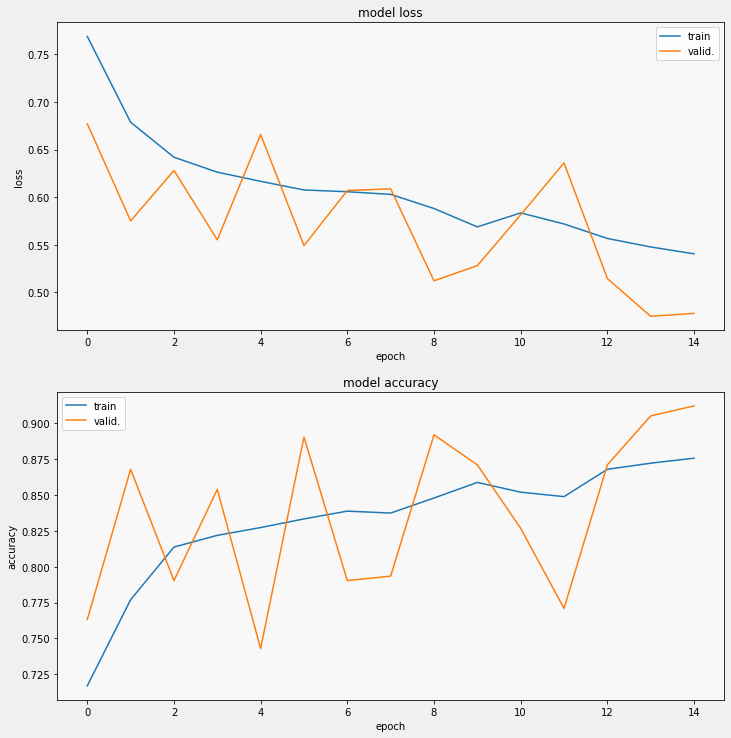

In [ ]:
display_training_curves(history_efnet.history['loss'], history_efnet.history['val_loss'], 'loss', 211)
display_training_curves(history_efnet.history['accuracy'], history_efnet.history['val_accuracy'], 'accuracy', 212)

In [ ]:
last_conv_layer_name = "top_conv"
classifier_layer_names = [
    "top_bn",
    "top_activation",
    "averagepooling2d_head",
    "flatten_head",
    "dense_head",
    "dropout_head",
    "predictions_head"
]

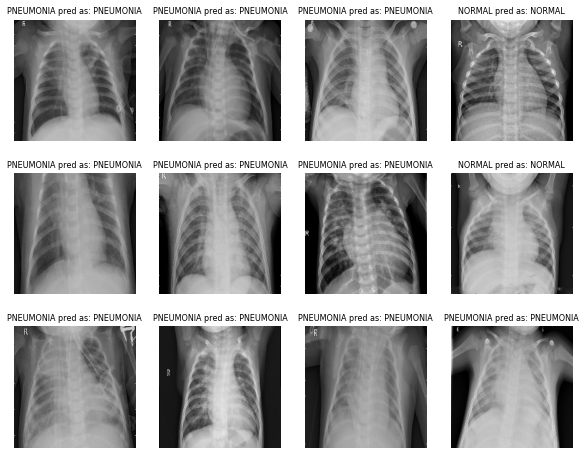

In [ ]:
# sample_data = testing_set.__getitem__(0)[0] 
# sample_label = testing_set.__getitem__(0)[1] 

plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')

    img = np.uint8(255 * sample_data[i])

    plt.imshow(img)
    plt.title(labels[np.argmax(sample_label[i])] + " pred as: " + labels[top_index], fontsize=8)

In [ ]:
model_efnet.save("model_efnet_30_09169.h5")

### Pretrained VGG

In [ ]:
pretrained_vgg = tf.keras.applications.VGG16(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

for layer in pretrained_vgg.layers:
  layer.trainable = False

x3 = pretrained_vgg.output
x3 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x3)
x3 = tf.keras.layers.Flatten(name="flatten_head")(x3)
x3 = tf.keras.layers.Dense(128, activation="relu", name="dense_head")(x3)
x3 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x3)
x3 = tf.keras.layers.Dense(64, activation="relu", name="dense_head_2")(x3)
x3 = tf.keras.layers.Dropout(0.5, name="dropout_head_2")(x3)
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions_head")(x3)

model_vgg = Model(inputs=pretrained_vgg.input, outputs=model_out)
model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=categorical_smooth_loss,metrics=['accuracy'])
# model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss="categorical_crossentropy",metrics=['accuracy'])
model_vgg.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "functional_201"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_____________________________________________________

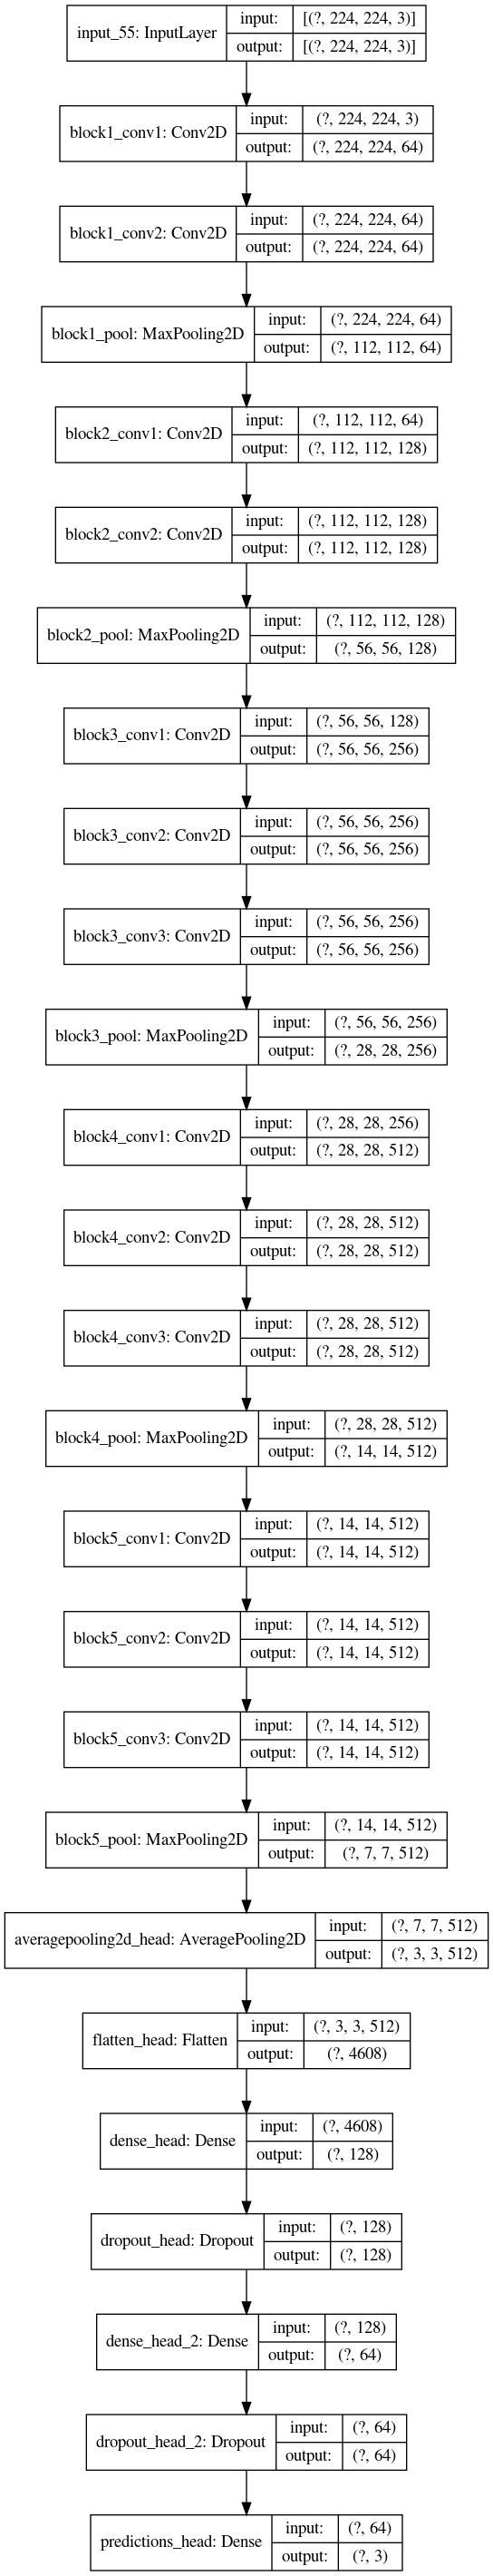

In [ ]:
plot_model(model_vgg, show_shapes=True, to_file='model_efnet.png')

In [ ]:
history_vgg = model_vgg.fit_generator(training_set, validation_data=testing_set, callbacks=[lr_reduce, es_callback], epochs=15)  

Epoch 1/15
322/322 [==============================] - 182s 566ms/step - loss: 0.8278 - accuracy: 0.6864 - val_loss: 0.5790 - val_accuracy: 0.8191
Epoch 2/15
322/322 [==============================] - 183s 567ms/step - loss: 0.6421 - accuracy: 0.8178 - val_loss: 0.5077 - val_accuracy: 0.8649
Epoch 3/15
322/322 [==============================] - 182s 564ms/step - loss: 0.5685 - accuracy: 0.8608 - val_loss: 0.4793 - val_accuracy: 0.8890
Epoch 4/15
322/322 [==============================] - 181s 562ms/step - loss: 0.5369 - accuracy: 0.8837 - val_loss: 0.4874 - val_accuracy: 0.8890
Epoch 5/15
322/322 [==============================] - 182s 565ms/step - loss: 0.5102 - accuracy: 0.9001 - val_loss: 0.4686 - val_accuracy: 0.8998
Epoch 6/15
322/322 [==============================] - 181s 563ms/step - loss: 0.4976 - accuracy: 0.9139 - val_loss: 0.4720 - val_accuracy: 0.9006
Epoch 7/15
322/322 [==============================] - 181s 563ms/step - loss: 0.4904 - accuracy: 0.9174 - val_loss: 0.4591 -

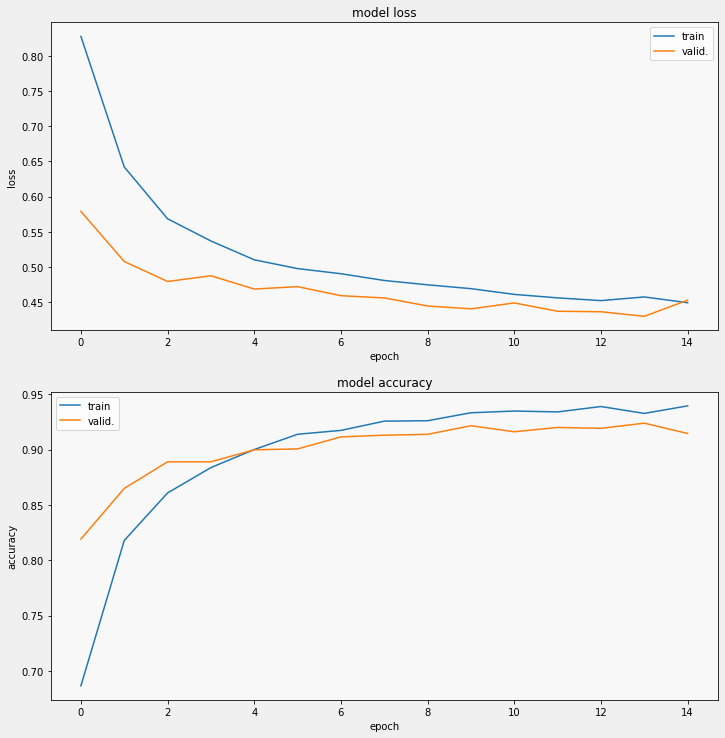

In [ ]:
display_training_curves(history_vgg.history['loss'], history_vgg.history['val_loss'], 'loss', 211)
display_training_curves(history_vgg.history['accuracy'], history_vgg.history['val_accuracy'], 'accuracy', 212)

In [ ]:
last_conv_layer_name = "block5_pool"
classifier_layer_names = [
    "averagepooling2d_head",
    "flatten_head",
    "dense_head",
    "dropout_head",
    "dense_head_2",
    "dropout_head_2",
    "predictions_head"
]

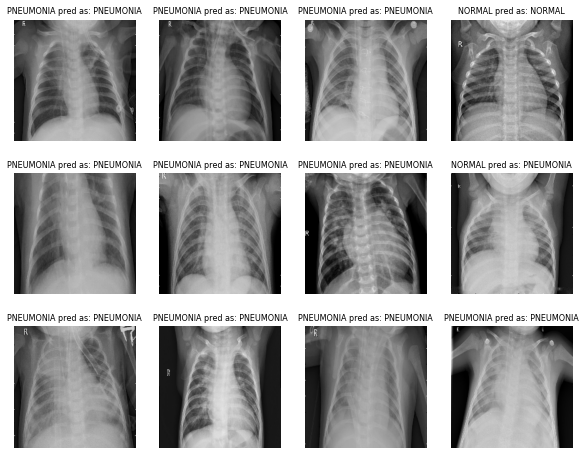

In [ ]:
plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')

    img = np.uint8(255 * sample_data[i])

    plt.imshow(img)
    plt.title(labels[np.argmax(sample_label[i])] + " pred as: " + labels[top_index], fontsize=8)

In [ ]:
model_vgg.save("model_vgg_30_09286.h5")

### Ensemble (simply at the last layer)
The network tries to find a combination of final probs (not the best way, but very simple where we have only 30 learnable parameters)

In [ ]:
# model_densenet
# model_efnet
# model_vgg

for layer in model_densenet.layers:
  layer.trainable = False

for layer in model_efnet.layers:
  layer.trainable = False

for layer in model_vgg.layers:
  layer.trainable = False

visible = tf.keras.layers.Input(shape=(image_size, image_size, 3), name="input")
x1 = model_densenet(visible)
x2 = model_efnet(visible)
x3 = model_vgg(visible)
merge = tf.keras.layers.concatenate([x1, x2, x3], name="concatallprobs")
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions")(merge)

model_densenet_efnet_vgg = Model(inputs=visible, outputs=model_out)
model_densenet_efnet_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
model_densenet_efnet_vgg.summary()

Model: "functional_251"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 3)            19428163    input[0][0]                      
__________________________________________________________________________________________________
functional_55 (Functional)      (None, 3)            65572499    input[0][0]                      
__________________________________________________________________________________________________
functional_201 (Functional)     (None, 3)            15313091    input[0][0]                      
_____________________________________________________________________________________

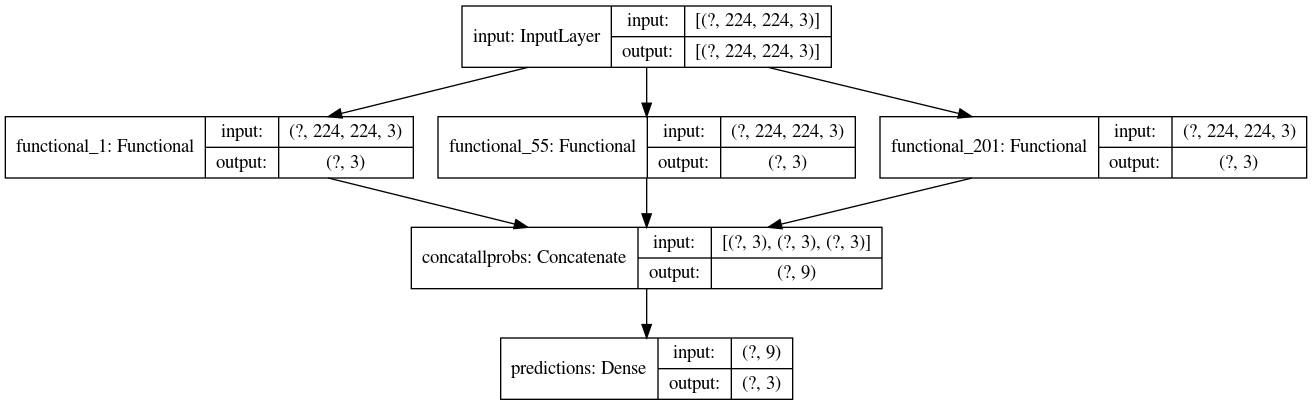

In [ ]:
plot_model(model_densenet_efnet_vgg, show_shapes=True, to_file='model_densenet_efnet_vgg.png')

In [ ]:
history = model_densenet_efnet_vgg.fit_generator(training_set, validation_data=testing_set, callbacks=[lr_reduce, es_callback], epochs=7)

Epoch 1/7
322/322 [==============================] - 220s 684ms/step - loss: 0.5045 - accuracy: 0.9572 - val_loss: 0.4738 - val_accuracy: 0.9387
Epoch 2/7
322/322 [==============================] - 213s 662ms/step - loss: 0.4589 - accuracy: 0.9609 - val_loss: 0.4332 - val_accuracy: 0.9379
Epoch 3/7
322/322 [==============================] - 213s 660ms/step - loss: 0.4203 - accuracy: 0.9566 - val_loss: 0.3995 - val_accuracy: 0.9371
Epoch 4/7
322/322 [==============================] - 211s 655ms/step - loss: 0.3879 - accuracy: 0.9611 - val_loss: 0.3711 - val_accuracy: 0.9371
Epoch 5/7
322/322 [==============================] - 212s 658ms/step - loss: 0.3622 - accuracy: 0.9570 - val_loss: 0.3471 - val_accuracy: 0.9379
Epoch 6/7
322/322 [==============================] - 213s 661ms/step - loss: 0.3363 - accuracy: 0.9633 - val_loss: 0.3265 - val_accuracy: 0.9379
Epoch 7/7
322/322 [==============================] - 211s 657ms/step - loss: 0.3130 - accuracy: 0.9598 - val_loss: 0.3087 - val_ac

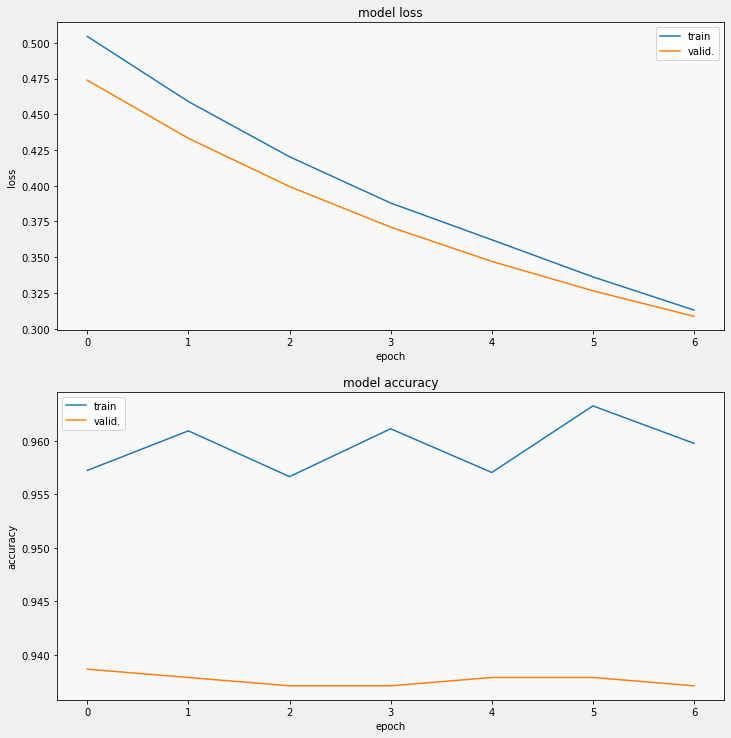

In [ ]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)

In [ ]:
model_densenet_efnet_vgg.save("model_densenet_efnet_vgg_09581.h5")

### Ensemble: without the heads
Gives the network the chance to learn from the dense layers before the softmax

In [ ]:
# model2= Model(inputs=model1.input, outputs=model1.get_layer(layer_name).output)

model_densenet_nohead = Model(inputs=model_densenet.input, outputs=model_densenet.get_layer("dense_head").output)
model_efnet_nohead = Model(inputs=model_efnet.input, outputs=model_efnet.get_layer("dense_head").output)
model_vgg_nohead = Model(inputs=model_vgg.input, outputs=model_vgg.get_layer("dense_head_2").output)

for layer in model_densenet_nohead.layers:
  layer.trainable = False

for layer in model_efnet_nohead.layers:
  layer.trainable = False

for layer in model_vgg_nohead.layers:
  layer.trainable = False

visible = tf.keras.layers.Input(shape=(image_size, image_size, 3), name="input")
x1 = model_densenet_nohead(visible)
x2 = model_efnet_nohead(visible)
x3 = model_vgg_nohead(visible)
merge = tf.keras.layers.concatenate([x1, x2, x3], name="concatallprobs")
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions")(merge)

model_densenet_efnet_vgg_nohead = Model(inputs=visible, outputs=model_out)
model_densenet_efnet_vgg_nohead.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy']) #categorical_smooth_loss
model_densenet_efnet_vgg_nohead.summary()

Model: "functional_259"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
functional_253 (Functional)     (None, 64)           19427968    input[0][0]                      
__________________________________________________________________________________________________
functional_255 (Functional)     (None, 64)           65572304    input[0][0]                      
__________________________________________________________________________________________________
functional_257 (Functional)     (None, 64)           15312896    input[0][0]                      
_____________________________________________________________________________________

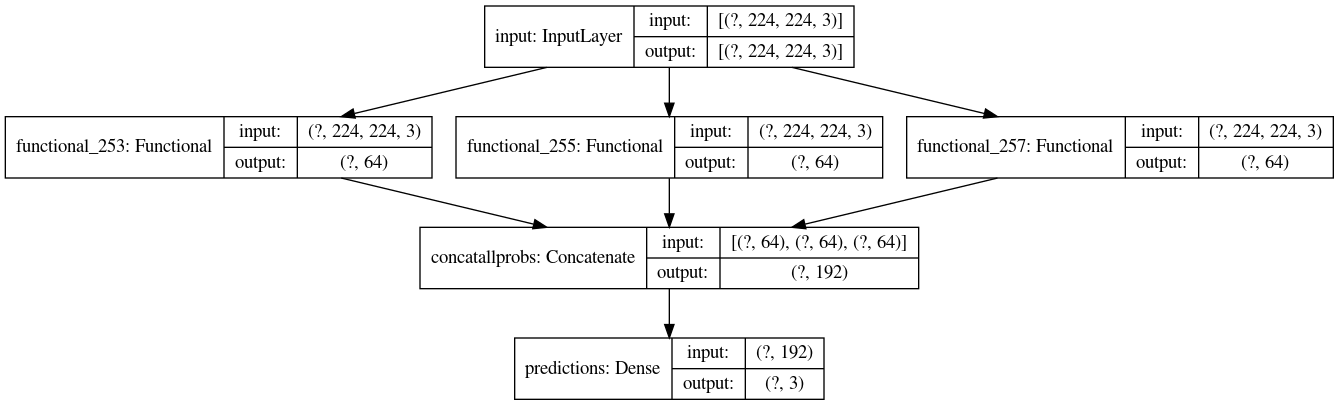

In [ ]:
plot_model(model_densenet_efnet_vgg_nohead, show_shapes=True, to_file='model_densenet_efnet_vgg_nohead.png')

In [ ]:
# training call backs 
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, epsilon=0.0001, patience=1, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [ ]:
history_nohead = model_densenet_efnet_vgg_nohead.fit_generator(training_set, validation_data=testing_set, callbacks=[lr_reduce, es_callback], epochs=10)

Epoch 1/10
322/322 [==============================] - 223s 691ms/step - loss: 0.1669 - accuracy: 0.9440 - val_loss: 0.1716 - val_accuracy: 0.9394
Epoch 2/10
169/322 [==============>...............] - ETA: 1:25 - loss: 0.0789 - accuracy: 0.9722

In [ ]:
model_densenet_efnet_vgg_nohead.save("model_densenet_efnet_vgg_nohead_09xxx.h5")

### Another setup: Ensembel with more shared layers

In [ ]:
# pretrained_densenet = tf.keras.applications.DenseNet201(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)
# pretrained_efnet = efn.EfficientNetB7(input_shape=(image_size, image_size, 3), weights='noisy-student', include_top=False)


# for layer in pretrained_densenet.layers:
#   layer.trainable = False

# for layer in pretrained_efnet.layers:
#   layer.trainable = False

# visible = tf.keras.layers.Input(shape=(image_size, image_size, 3))

# # x1 = pretrained_densenet.output
# x1 = pretrained_densenet(visible)
# x1 = tf.keras.layers.AveragePooling2D()(x1)
# x1 = tf.keras.layers.Flatten()(x1)
# x1 = tf.keras.layers.Dense(32, activation="relu")(x1)
# x1 = tf.keras.layers.Dropout(0.5)(x1)
# #x1 = tf.keras.layers.Dense(64, activation="relu")(x1)

# # x2 = pretrained_efnet.output
# x2 = pretrained_efnet(visible)
# x2 = tf.keras.layers.AveragePooling2D()(x2)
# x2 = tf.keras.layers.Flatten()(x2)
# x2 = tf.keras.layers.Dense(32, activation="relu")(x2)
# x2 = tf.keras.layers.Dropout(0.5)(x2)
# #x2 = tf.keras.layers.Dense(64, activation="relu")(x2)

# merge = tf.keras.layers.concatenate([x1, x2])
# x = tf.keras.layers.Dense(32, activation='relu')(merge)
# x = tf.keras.layers.Dropout(0.5)(x)
# model_out = tf.keras.layers.Dense(3, activation='softmax')(x)

# #model_densenet = Model(inputs=pretrained_densenet.input, outputs=out_dense_model)
# model_densenet_efnet = Model(inputs=visible, outputs=model_out)
# model_densenet_efnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
# model_densenet_efnet.summary()